In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import keras
import os
from keras.models import Sequential # Sequential Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout #to avoid overfitting

from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns
import seaborn.regression as snsl
import datetime
import tushare as ts

from sklearn.preprocessing import MinMaxScaler
import fix_yahoo_finance as yf

In [75]:
# load certain stock training data from yahoo finance 
stock_train = yf.download("SPY", start="2013-10-25", end="2018-10-23")

[*********************100%***********************]  1 of 1 downloaded


In [76]:
stock_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-24,174.919998,175.369995,174.509995,175.149994,158.690445,70350000
2013-10-25,175.509995,176.000000,175.169998,175.949997,159.415329,93625000
2013-10-28,175.889999,176.470001,175.699997,176.229996,159.669006,84979000
2013-10-29,176.630005,177.240005,176.380005,177.169998,160.520660,87401000
2013-10-30,177.380005,177.509995,175.660004,176.289993,159.723328,140002000


In [77]:
# load certain stock testing data 
stock_test = yf.download("SPY", start="2018-10-26", end="2018-11-26")

[*********************100%***********************]  1 of 1 downloaded


In [78]:
stock_training = stock_train.iloc[:,1:2].values
stock_train.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [79]:
sc = MinMaxScaler(feature_range=(0,1))
stock_training_scaled = sc.fit_transform(stock_training)

In [80]:
X_train = []
y_train = []

# Split training data 
for i in range(60, stock_train.shape[0]):
    X_train.append(stock_training_scaled[i-60:i,0])
    y_train.append(stock_training_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshape
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1], 1))


In [81]:
# Model
def build_regressor():
    
    
    regressor = Sequential() 
    
    #add the first LSTM and dropout to avoid overfitting
    regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1))) 
    regressor.add(Dropout(0.2))
    
    #add the second LSTM and dropout to avoid overfitting
    regressor.add(LSTM(units = 50, return_sequences=True)) 
    regressor.add(Dropout(0.2))
     
    #add the third LSTM and dropout to avoid overfitting
    regressor.add(LSTM(units = 50, return_sequences=True)) 
    regressor.add(Dropout(0.2))
     
    #add the fourth LSTM and dropout to avoid overfitting
    regressor.add(LSTM(units = 50)) 
    regressor.add(Dropout(0.2))
    
    #add the output layer
    regressor.add(Dense(units=1))
    
    return regressor



In [82]:
regressor = build_regressor()  
regressor.compile(optimizer='adam', loss = 'mean_squared_error')   

#Fit 
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

# real stock price
real_price = stock_test.iloc[:,1:2].values

dataset = pd.concat((stock_train['Close'],stock_test['Close']), axis=0)  
inputs = dataset[ len(dataset) - len(stock_test) -60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

Epoch 1/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0473
Epoch 2/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0053
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0039
Epoch 4/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0043
Epoch 5/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0035
Epoch 6/100
1198/1198 [==============================] - 7s 5ms/step - loss: 0.0036
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0035
Epoch 8/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0044
Epoch 9/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0035
Epoch 10/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0031
Epoch 11/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0033
Epoch 12/100
1198/1198 [==============================] - 6s 5ms/step - l

1198/1198 [==============================] - 6s 5ms/step - loss: 0.0010
Epoch 98/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0011
Epoch 99/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0010
Epoch 100/100
1198/1198 [==============================] - 6s 5ms/step - loss: 9.9380e-04


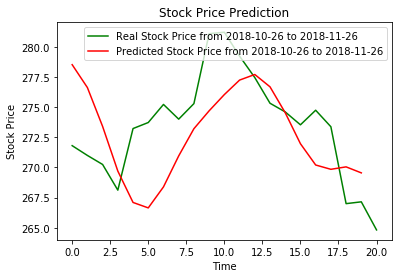

<Figure size 432x288 with 0 Axes>

In [83]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i,0])

X_test= np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1], 1))

# Use the model to predict the stock price 
predicted_stock = regressor.predict(X_test)
predicted_stock = sc.inverse_transform(predicted_stock)

#Graph 
plt.plot(real_price,color='green', label='Real Stock Price from 2018-10-26 to 2018-11-26')
plt.plot(predicted_stock,color='red', label='Predicted Stock Price from 2018-10-26 to 2018-11-26')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.savefig(os.path.join('figures', 'SPYpredict.png'), format='png', dpi=300)